In [1]:
!pip install gym[classic_control] --upgrade gym

You should consider upgrading via the 'c:\users\jonathan\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
import random
from collections import deque
import numpy as np

import gym
import torch
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import moviepy

c:\Users\Jonathan\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from IPython.display import HTML
from base64 import b64encode

def show_video(file_name):
    mp4 = open(file_name, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [4]:
class QualityNN(torch.nn.Module):
    def __init__(self, observation_space, action_space):
        super(QualityNN, self).__init__()
        self.linear = torch.nn.Sequential(
                  torch.nn.Linear(observation_space, 16),
                  torch.nn.ReLU(),
                  torch.nn.Linear(16,32),
                  torch.nn.ReLU(),
                  torch.nn.Linear(32, action_space)
                )

    def forward(self, x):
        return self.linear(x)

In [5]:
class Memory(object):
    def __init__(self, max_size=100):
        self.memory = deque(maxlen=max_size)

    def push(self, element):
        self.memory.append(element)

    def get_batch(self, batch_size=4):
        batch_size = min(batch_size, len(self))
        return random.sample(self.memory, batch_size)

    def __repr__(self):
        return f"Current elements in memory: {len(self.memory)}"

    def __len__(self):
        return len(self.memory)

In [6]:
class Agent(object):
    def __init__(self, environment):
        self.decay = 0.99
        self.randomness = 1.00
        self.min_randomness = 0.001
        self.learning_rate = 1e-3
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = QualityNN(environment.observation_space.shape[0], environment.action_space.n).to(self.device)

        self.target_model = QualityNN(environment.observation_space.shape[0], environment.action_space.n).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)


    def act(self, state):
        with torch.no_grad():
            self.model.eval()

            state = torch.tensor(state).to(self.device)
            qualities = self.model(state).cpu()

        if np.random.rand() <= self.randomness:
            action = np.random.randint(low=0, high=qualities.size(dim=0))
        else:
            action = torch.argmax(qualities).item()

        return action, qualities.numpy()

    def update(self, memory_batch):
        states      = torch.tensor([s[0] for s in memory_batch], dtype=torch.float32, device=self.device)
        actions     = torch.tensor([s[2] for s in memory_batch], dtype=torch.int64, device=self.device)
        rewards     = torch.tensor([s[3] for s in memory_batch], dtype=torch.float32, device=self.device)

        non_final_next_states = torch.tensor([s[1] for s in memory_batch if s[1] is not None], dtype=torch.float32, device=self.device)
        non_final_mask = torch.tensor([s[1] is not None for s in memory_batch], dtype=torch.bool)

        self.model.train()
        q_values = self.model(states)

        state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())
        with torch.no_grad():
          self.target_model.eval()
          q_values_target = self.target_model(non_final_next_states)
          next_state_max_q_values = torch.zeros(len(memory_batch), device=self.device)
          next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

        expected_state_action_values = rewards + (next_state_max_q_values * self.decay)
        expected_state_action_values = expected_state_action_values.unsqueeze(1)

        loss = torch.nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 2)
        self.optimizer.step()

        return loss.item()

    def update_randomness(self):
        self.randomness *= self.decay
        self.randomness = max(self.randomness, self.min_randomness)

In [7]:
max_iteration = 5000
logging_iteration = 100
learning = []
losses = []

environment = gym.wrappers.RecordVideo(
    gym.make("Acrobot-v1", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda x: x % logging_iteration == 0
)
agent = Agent(environment)
memory = Memory(max_size=10000)

for iteration in range(1, max_iteration + 1):
    steps = 0
    done = False
    state, _ = environment.reset()

    while not done:
        action, q_values = agent.act(state)
        next_state, reward, done, *_ = environment.step(action)

        memory.push(element=(state, next_state, action, reward))
        state = next_state
        steps += 1
        
        if steps == 500:
          done = True

    batch_losses = []
    for _ in range(1, 64):
      memory_batch = memory.get_batch(batch_size=64)
      loss = agent.update(memory_batch)
      batch_losses.append(loss)
    losses.append(np.mean(batch_losses))
    agent.update_randomness()

    learning.append(steps)
    if iteration % logging_iteration == 0:
        print(f"Iteration: {iteration}")
        print(f"  Moving-Average Steps: {np.mean(learning[-logging_iteration:]):.4f}")
        print(f"  Memory-Buffer Size: {len(memory.memory)}")
        print(f"  Agent Randomness: {agent.randomness:.3f}")
        print(f"  Average Loss: {np.mean(losses[-logging_iteration:]):.6f}")
        print()


c:\Users\Jonathan\AppData\Local\Programs\Python\Python38\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-0.mp4



C:\Users\Jonathan\AppData\Local\Temp\ipykernel_24252\109359244.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  states      = torch.tensor([s[0] for s in memory_batch], dtype=torch.float32, device=self.device)


Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-0.mp4
Iteration: 100
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.366
  Average Loss: 0.002625

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-100.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-100.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-100.mp4
Iteration: 200
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.134
  Average Loss: 0.000002

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-200.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-200.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-200.mp4
Iteration: 300
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.049
  Average Loss: 0.000001

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-300.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-300.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-300.mp4
Iteration: 400
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.018
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-400.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-400.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-400.mp4
Iteration: 500
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.007
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-500.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-500.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-500.mp4
Iteration: 600
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.002
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-600.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-600.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-600.mp4
Iteration: 700
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-700.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-700.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-700.mp4
Iteration: 800
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-800.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-800.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-800.mp4
Iteration: 900
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-900.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-900.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-900.mp4
Iteration: 1000
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1000.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1000.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1000.mp4
Iteration: 1100
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1100.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1100.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1100.mp4
Iteration: 1200
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1200.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1200.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1200.mp4
Iteration: 1300
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1300.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1300.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1300.mp4
Iteration: 1400
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1400.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1400.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1400.mp4
Iteration: 1500
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1500.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1500.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1500.mp4
Iteration: 1600
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1600.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1600.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1600.mp4
Iteration: 1700
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1700.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1700.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1700.mp4
Iteration: 1800
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1800.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1800.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1800.mp4
Iteration: 1900
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1900.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1900.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-1900.mp4
Iteration: 2000
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-2000.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-2000.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-2000.mp4
Iteration: 2100
  Moving-Average Steps: 500.0000
  Memory-Buffer Size: 10000
  Agent Randomness: 0.001
  Average Loss: 0.000000

Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-2100.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-2100.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\RL_Learning\videos\rl-video-episode-2100.mp4


KeyboardInterrupt: 

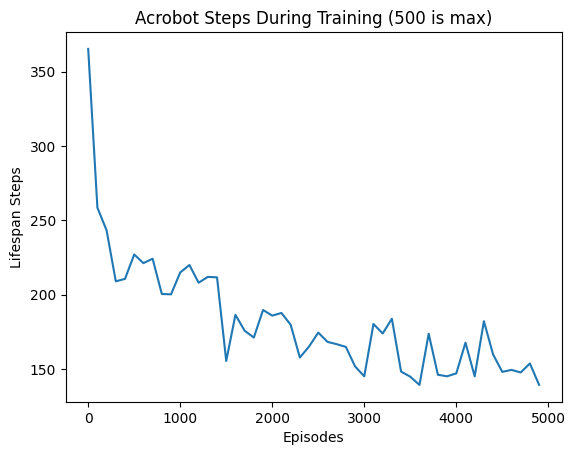

In [ ]:
x = np.arange(0, len(learning), logging_iteration)
y = np.add.reduceat(learning, x) / logging_iteration

sns.lineplot(x=x, y=y)
plt.title("Acrobot Steps During Training (500 is max)")
plt.xlabel("Episodes")
plt.ylabel("Lifespan Steps")
plt.show()

In [ ]:
display(show_video(f"./videos/rl-video-episode-1400.mp4"))